In [1]:
%pip install zss
%pip install lxml
%pip install pandas
%pip install  seaborn==0.13.0
%pip install -U sentence-transformers
%pip install gensim
%pip install levenshtein


[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: /opt/homebrew/Cellar/jupyterlab/4.0.12/libexec/bin/python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: /opt/homebrew/Cellar/jupyterlab/4.0.12/libexec/bin/python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: /opt/homebrew/Cellar/jupyterlab/4.0.12/libexec/bin/python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
  Using cached seaborn-0.13.0-py3-none-any.whl.metadata (5.3 kB)
Using cached seaborn-0.13.0-py3-none-any.whl (294 kB)
  Attempting uninstall: seaborn
    Found existing installation: seaborn 0.12.0
    Uninstalling seaborn-0.12.0:
      Successfully uninstalled seaborn-0.12.0

[notice

In [2]:
import xml.etree.ElementTree as ET
from zss import simple_distance, distance, Node
import numpy as np
import zss
import pandas as pd
# import pkg_resources
# pkg_resources.require("seaborn==0.13.0")
import seaborn as sns
import matplotlib.pyplot as plt
import gensim
import gensim.downloader as api
dataset = api.load("text8")
import pickle
print("Seaborn Version: " + sns.__version__)

Seaborn Version: 0.13.0


# Basic ZSS + Setup

In [3]:

A = (
    Node("f")
        .addkid(Node("a")
            .addkid(Node("h"))
            .addkid(Node("c")
                .addkid(Node("l"))))
        .addkid(Node("e"))
    )
B = (
    Node("f")
        .addkid(Node("a")
            .addkid(Node("d"))
            .addkid(Node("c")
                .addkid(Node("b"))))
        .addkid(Node("e"))
    )

In [4]:
print(simple_distance(A, B, return_operations=True))

(2.0, [<Operation Update>, <Operation Update>, <Operation Match>, <Operation Match>, <Operation Match>, <Operation Match>])


In [5]:
tree = ET.parse("data/AT1/ICS2-01.xml")
# with open("data/AT1/ICS2-01.xml", "r") as f:
#     data = f.read()
root = tree.getroot()[0]
print(root.attrib["refinement"])
print(root[0].text)
print(root[1:len(root)])
print(len(root))

disjunctive
Gathering personal data
[<Element 'node' at 0x105efd350>, <Element 'node' at 0x176c02d90>, <Element 'node' at 0x176c02fc0>]
4


In [127]:
OR = 0
AND = 1
SAND = 2

class AttackNode(object):

    def __init__(self, label, refinement=OR, children = []):
        self.label = label
        self.refinement = refinement
        self.children = children
        self.depth = -1
        self.position = -1
        self.parent = None
    
    @staticmethod
    def get_children(node):
        return node.children

    @staticmethod
    def get_label(node):
        return node.label

    def get_parent(node):
        return self.parent

    def get_refinement(node):
        return node.refinement

    def set_parents(self):
        for node in self.children:
            node.set_parents()
            node.parent = self

    def get_multiset(self):
        if self.children == []:
            return [[self.label]]
        else:
            if self.refinement == OR:
                toReturn = []
                for child in self.children:
                    ms = child.get_multiset()
                    for i in ms:
                        toReturn.append(i)
                return toReturn
            elif self.refinement == AND:
                toReturn = []
                for i in range(len(self.children)):
                    if i == 0:
                        toReturn = [[x[0]] for x in self.children[i].get_multiset()]
                    else:
                        toReturn = [[x[0], y[0]] for x in toReturn for y in self.children[i].get_multiset()]
                        
                return toReturn
            

    def addkid(self, node, before=False):
        node.parent = self
        if before:  
            self.children.insert(0, node)
        else:   
            self.children.append(node)
        return self

    def __str__(self):
        # print(self.refinement, type(self.refinement))
        rest = ""
        if len(self.children) > 0:
            if self.refinement == OR:
                rest = " OR ("
            elif self.refinement == AND:
                rest = " AND ("
            for i in range(len(self.children)):
                rest += str(self.children[i])
                # if isinstance(self.children[i], str):
                #     rest += self.children[i]
                # else :
                #     rest += self.children[i].label
                if i != len(self.children)-1:
                    rest += ", "
            rest += ")"
        return self.label + rest 

    def __eq__(self, other):
        return self.label == other.label and self.refinement == other.refinement and len(self.children) == len(other.children)
        

def xmlToZSSTree(file):
    tree = ET.parse(file)
    root = tree.getroot()[0]
    ZSSTree = XMLZSSNode(root)
    return ZSSTree
    
def XMLZSSNode(node):
    label = node[0].text
    # print(label)
    refinement = node.attrib["refinement"]
    if refinement == "disjunctive":
        refinement = OR
    elif refinement == "conjunctive":
        refinement = AND
    else:
        print(refinement)
        
    children = []
    if len(node) > 1:
        xml_children = node[1:len(node)]
        for i in xml_children:
            children.append(XMLZSSNode(i))
    return AttackNode(label, refinement, children)



def number_tree(root):
    current_depth = 1
    node_dict = {}
    node_dict[current_depth] = []
    depths = [current_depth]

    # Basic BFS on the tree
    node_dict[current_depth].append(root)
    for depth in depths:
        for node in node_dict[depth]:
            if not depth + 1 in node_dict.keys():
                if node.children != []:
                    node_dict[depth + 1] = []
                    if depths[-1] != depth + 1:
                        depths.append(depth + 1)
            for child in node.children:
                node_dict[depth + 1].append(child)

    for depth in node_dict.keys():
        number = 1
        for node in node_dict[depth]:
            node.depth = depth
            node.position = number
            number += 1
    return node_dict


# i = 12
# T1 = xmlToZSSTree("data/AT1/ICS2-"+str(i)+".xml")
# tdict = numberTree(T1)
# for key in tdict.keys():
#     for node in tdict[key]:
#         print(node.label, node.depth, node.position)
    
    

    

<Axes: >

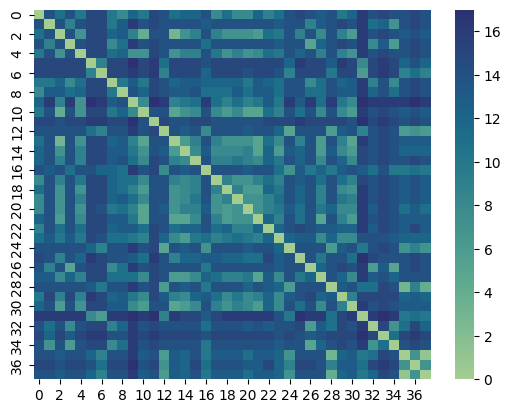

In [10]:


data = []
for i in range(1, 39):
    temp = []
    for j in range(1, 39):
        if i < 10:
            i = "0" + str(i)
        if j < 10:
            j = "0" + str(j)
        T1 = xmlToZSSTree("data/AT1/ICS2-"+str(i)+".xml")
        T2 = xmlToZSSTree("data/AT1/ICS2-"+str(j)+".xml")
        dist = simple_distance(T1, T2)#, return_operations=True))
        temp.append(dist)
        # print(i, j, dist)
        i = int(i)
        j = int(j)
    data.append(temp)

simple_df = pd.DataFrame(data)
# print(simple_df)        

sns.heatmap(simple_df, annot=False, cmap="crest")

# print(T1, T2)
# print(simple_distance(T1, T2, return_operations=True))

## Simple Distance

14.560455192034139


<Axes: >

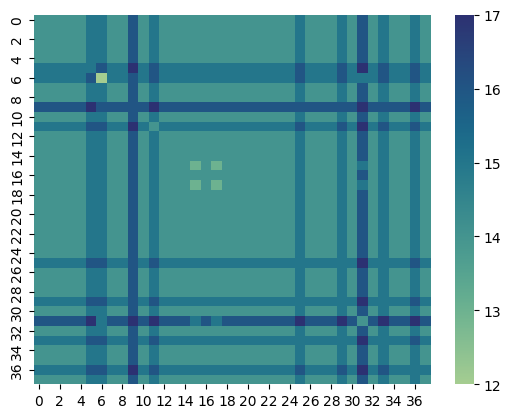

In [8]:
def insert(a):
    return 1
def remove(a):
    return 1
def update(a, b):
    if a == b:
        return 0
    else:
        return 1


data = []
unique = []
for i in range(1, 39):
    temp = []
    for j in range(1, 39):
        if i < 10:
            i = "0" + str(i)
        if j < 10:
            j = "0" + str(j)
        T1 = xmlToZSSTree("data/AT1/ICS2-"+str(i)+".xml")
        T2 = xmlToZSSTree("data/AT1/ICS2-"+str(j)+".xml")
        dist = distance(T1, T2, Node.get_children, insert, remove, update)
        temp.append(dist)
        if int(i) < int(j):
            unique.append(dist)
        # print(i, j, dist)
        i = int(i)
        j = int(j)
    data.append(temp)

simple_df = pd.DataFrame(data)
# print(simple_df)        

print(sum(unique)/len(unique))
sns.heatmap(simple_df, annot=False, cmap="crest")

## Structual Only

Nodes can be updated at no cost - so the only cost is with adding and subtracting nodes. Hence this is a comparison of construction.

0.9630156472261735


<Axes: >

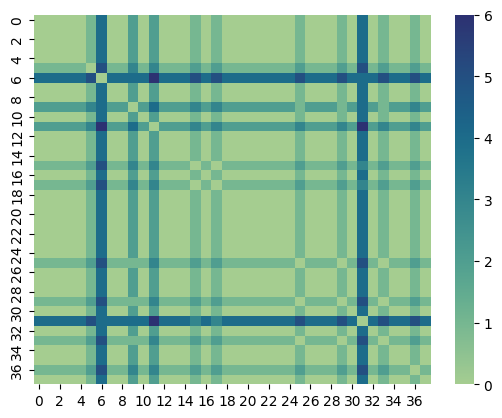

In [20]:
def insert(a):
    return 1
def remove(a):
    return 1
def update(a, b):
    return 0
    if a == b:
        return 0
    else:
        return 1


data = []
unique = []
for i in range(1, 39):
    temp = []
    for j in range(1, 39):
        if i < 10:
            i = "0" + str(i)
        if j < 10:
            j = "0" + str(j)
        T1 = xmlToZSSTree("data/AT1/ICS2-"+str(i)+".xml")
        T2 = xmlToZSSTree("data/AT1/ICS2-"+str(j)+".xml")
        dist = distance(T1, T2, Node.get_children, insert, remove, update)
        temp.append(dist)
        if int(i) < int(j):
            unique.append(dist)
        # print(i, j, dist)
        i = int(i)
        j = int(j)
    data.append(temp)

simple_df = pd.DataFrame(data)
# print(simple_df)        

print(sum(unique)/len(unique))
sns.heatmap(simple_df, annot=False, cmap="crest")

0.9630156472261735


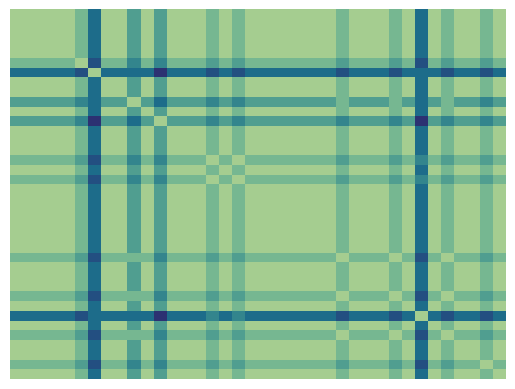

In [13]:
def insert(a):
    return 1
def remove(a):
    return 1
def update(a, b):
    return 0


data = []
unique = []
for i in range(1, 39):
    temp = []
    for j in range(1, 39):
        if i < 10:
            i = "0" + str(i)
        if j < 10:
            j = "0" + str(j)
        T1 = xmlToZSSTree("data/AT1/ICS2-"+str(i)+".xml")
        T2 = xmlToZSSTree("data/AT1/ICS2-"+str(j)+".xml")
        dist = distance(T1, T2, Node.get_children, insert, remove, update)
        temp.append(dist)
        if int(i) < int(j):
            unique.append(dist)
        # print(i, j, dist)
        i = int(i)
        j = int(j)
    data.append(temp)

print(sum(unique)/len(unique))
simple_df = pd.DataFrame(data)
# print(simple_df)        


ax = sns.heatmap(simple_df, annot=False, cmap="crest",  yticklabels=False,  xticklabels=False, cbar=False)
ax.tick_params(left=False, bottom=False)
plt.savefig("img/test.png")

# Semantic Similarity

In [ ]:
# data = [i for i in dataset]
# def tagged_document(list_of_list_of_words):
#    for i, list_of_words in enumerate(list_of_list_of_words):
#       yield gensim.models.doc2vec.TaggedDocument(list_of_words, [i])
 
# training_data = list(tagged_document(data))
# model = gensim.models.doc2vec.Doc2Vec(vector_size=40, min_count=2, epochs=30)
 
# model.build_vocab(training_data)
# model.train(training_data, total_examples=model.corpus_count, epochs=model.epochs)

In [12]:
# for i in store.keys():
#     for j in store[i].keys():
#         for k in store[i][j].keys():
#             store[i][j][k] = abs(store[i][j][k])

In [13]:

# sentences = [
#     'what is the weather tomorrow',
#     'will it rain tomorrow',
# ]
# embedding = model.encode(sentences, convert_to_tensor=False)
# embedding.shape
# cosine_scores = util.cos_sim(embedding, embedding)
# print(cosine_scores)
# print(float(cosine_scores[0][1]))

# d = {}
# for i, v1 in enumerate(sentences):
#     for j, v2 in enumerate(sentences):
#         if i >= j:
#             continue
#         d[v1 + ' vs. ' + v2] = cosine_scores[i][j].item()

# # sort by score
# d_sorted = dict(sorted(d.items(), key=lambda x: x[1], reverse=True))
# d_sorted


In [8]:
from math import sqrt, pow, exp
from sentence_transformers import SentenceTransformer, util
model_key = 'all-MiniLM-L12-v2'
# model_key = 'all-mpnet-base-v2'


 
def squared_sum(x):
  """ return 3 rounded square rooted value """
 
  return round(sqrt(sum([a*a for a in x])),3)
 
def euclidean_distance(x,y):
  """ return euclidean distance between two lists """
 
  return sqrt(sum(pow(a-b,2) for a, b in zip(x, y)))

def cos_similarity(x,y):
  """ return cosine similarity between two lists """
 
  numerator = sum(a*b for a,b in zip(x,y))
  denominator = squared_sum(x)*squared_sum(y)
  return round(numerator/float(denominator),3)


current_key = "not this"

def compare(a, b):
    global current_key
    if current_key != model_key:
        global model
        model = SentenceTransformer(model_key)
        print(current_key)
        current_key = model_key
        print(model, current_key)
    embedding = model.encode([a,b], convert_to_tensor=False)
    cosine_scores = util.cos_sim(embedding, embedding)
    print(a, b, abs(round(float(float(cosine_scores[0][1])),4)))
    return abs(round(float(float(cosine_scores[0][1])),4))
    # vectors = [model.infer_vector([word for word in sent]).reshape(1,-1) for sent in [a, b]]
    # # print(vectors[0])
    # return cos_similarity(vectors[0][0],vectors[1][0])


# This is just the compare function but all combinations are stored in a massive dictionary - this is to speed up computations for common attack trees
def stored_compare(a, b):
    temp = [a, b]
    temp.sort()
    a = temp[0]
    b = temp[1]
    if a in store[model_key]:
        if b in store[model_key][a]:
            return store[model_key][a][b]
        else:
            # embedding = model.encode([a,b], convert_to_tensor=False)
            # cosine_scores = util.cos_sim(embedding, embedding)
            store[model_key][a][b] =  compare(a, b)
            return store[model_key][a][b]    
    else:
        store[model_key][a] = {}
        # embedding = model.encode([a,b], convert_to_tensor=False)
        # cosine_scores = util.cos_sim(embedding, embedding)
        store[model_key][a][b] =  compare(a, b)
        return store[model_key][a][b]
    

/opt/homebrew/Cellar/jupyterlab/4.0.12/libexec/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [250]:
# with open('similarity_store_AT2', 'wb') as fp:
#     pickle.dump(store, fp) 


In [254]:
with open('similarity_store_AT2', 'rb') as fp:
    store = pickle.load(fp)

dict_keys(['Social engineering', 'Stealing phone', 'Remote access', 'Accessing the profile', 'Request for additional data', 'User profiling', 'Credential creep', 'Linking the dataset', 'Obtaining a sensitive dataset', 'Background data attack', 'Malware', 'Gaining user credentials', 'Unauthorized access to profile', 'Gathering personal data', 'Social Engineering Attack', 'Remote Access', 'Steal Phone', 'Access Profile', 'Request for Verification', 'Obtain Sensitive Dataset', 'Background Data Attack', 'User Profiling', 'Request Additional Data', 'Credential Creep', 'Malware Attack', 'Gain User Credentials', 'Unauthorized Profile Access', 'Obtain Personal Data', 'Social engineering attack', 'Steal a phone', 'Access the profile', 'Submit a request for additional data other than what is needed for verification', 'Link the dataset via a request for verification', 'Obtain a sensitive dataset', 'Malware attack', 'Gain user credentials', 'Obtain personal data', 'Accessing Profile', 'Request For

In [10]:
model = SentenceTransformer(model_key)
print(model)

SentenceTransformer(
  (0): Transformer({'max_seq_length': 128, 'do_lower_case': False}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 384, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
  (2): Normalize()
)


# XML Ingestion

In [255]:
import time

# mks = ['paraphrase-multilingual-MiniLM-L12-v2', 'all-mpnet-base-v2', 'all-MiniLM-L12-v2', "normalized_levenshtein"]
mks = ['paraphrase-multilingual-MiniLM-L12-v2', 'all-mpnet-base-v2', 'all-MiniLM-L12-v2']

# mks = ['all-MiniLM-L12-v2', "normalized_levenshtein"]
# mks = ['paraphrase-multilingual-MiniLM-L12-v2', 'all-mpnet-base-v2']


# mks = ["normalized_levenshtein"]
lims = []
for i in range(0,10):
    # lims.append(round(.1*i,4))
    for j in range(0,10):
        lims.append(round(.1*i+.01*j, 4))
lims.append(1)
# lims.append(1.001)
    # lims.extend([round(.9 + .01*i, 4) for i in range(0, 7)])
    # lims.extend([round(.96 + .001*i, 4) for i in range(0, 10)])
    # lims.extend([round(.97 + .001*i, 4) for i in range(0, 10)])
    # lims.extend([round(.98 + .001*i, 4) for i in range(0, 10)])
    # lims.extend([round(.99 + .001*i, 4) for i in range(0, 10)])
    # lims.append(1)
    
def insert(a):
    return 1
def remove(a):
    return 1
# lim = .9
# model_key = "normalized_levenshtein"
def update(a, b):
    if model_key == "normalized_levenshtein":
        comp = Levenshtein.distance(a.label, b.label)
        comp = 1 - comp/np.max([len(a.label.replace(" ", "")), len(b.label.replace(" ", ""))])
    else:
        comp = stored_compare(a.label, b.label)
    
    if comp > 1:
        print(a.label, b.label, comp)
    if  comp >= lim:
        return 0
    else:
        return 1


def avg_dist(ATtype = "AT1"):
    start = time.time()
    data = []
    operations = []
    unique = []
    for i in range(1, 39):
        temp = []
        for j in range(1, 39):
            if ATtype == "AT2" and ((i == 27 or j == 27) or (i == 28 or j == 28) or (i == 38 or j == 38)):
                continue
            if k == lims[0]:
                print("Processing: ", i, " & ",j)
            if i < 10:
                i = "0" + str(i)
            if j < 10:
                j = "0" + str(j)
            # T1 = xmlToZSSTree("data/" + ATtype + "/ICS2-"+str(i)+".xml")
            T1 = xmlToZSSTree("data/" + ATtype + "/ICS2-"+str(i)+".xml")
            T2 = xmlToZSSTree("data/" + ATtype + "/ICS2-"+str(j)+".xml")
            # dist, opers = label_distance(T1, T2, lim)
            # dist, opers = recursive_radical_distance(T1, T2, lim)
            dist, opers = multiset_distance(T1, T2, lim)
            # dist, opers = distance(T1, T2, AttackNode.get_children, insert, remove, update, True)
            # dist, opers = simple_distance(T1, T2, AttackNode.get_children, return_operations=True)
            temp.append(dist)
            if int(i) < int(j):
                unique.append(dist)
                # #Simplify operations - hopefully improve storage size
                # top = []
                # for op in opers:
                #     if op.type == 0:
                #         top.append((op.type, op.arg1.label))
                #     elif op.type == 1:
                #         top.append((op.type, op.arg2.label))
                #     else:
                #         top.append((op.type, op.arg1.label, op.arg2.label))
                # operations.append((i, j, top))
                operations.append((i, j, opers))
            # print(i, j, dist)
            i = int(i)
            j = int(j)
        data.append(temp)
    end = time.time()
    print(model_key, lim, end - start, sum(unique)/len(unique))
    simple_df = pd.DataFrame(data)
    return simple_df, operations

def avg_dist_self_compare():
    start = time.time()
    data = []
    operations = []
    unique = []
    for i in range(1, 39):
        temp = []
        if ((i == 27) or (i == 28) or (i == 38)):
            continue
        if k == lims[0]:
            print("Processing: ", i, " & ",j)
        if i < 10:
            i = "0" + str(i)
        T1 = xmlToZSSTree("data/" + "AT1" + "/ICS2-"+str(i)+".xml")
        T2 = xmlToZSSTree("data/" + "AT2" + "/ICS2-"+str(i)+".xml")
        # T2 = xmlToZSSTree("data/" + ATtype + "/ICS2-"+str(j)+".xml")
        # dist, opers = recursive_radical_distance(T1, T2, lim)
        dist, opers = multiset_distance(T1, T2, lim)
        # dist, opers = distance(T1, T2, AttackNode.get_children, insert, remove, update, True)
        # dist, opers = simple_distance(T1, T2, AttackNode.get_children, return_operations=True)
        temp.append(dist)
        unique.append(dist)
        # #Simplify operations - hopefully improve storage size
        # top = []
        # for op in opers:
        #     if op.type == 0:
        #         top.append((op.type, op.arg1.label))
        #     elif op.type == 1:
        #         top.append((op.type, op.arg2.label))
        #     else:
        #         top.append((op.type, op.arg1.label, op.arg2.label))
        # operations.append((i, j, top))
        operations.append((i, j, opers))
        # print(i, j, dist)
        i = int(i)
        data.append(temp)
    end = time.time()
    print(model_key, lim, end - start, sum(unique)/len(unique))
    simple_df = pd.DataFrame(data)
    return simple_df, operations

# all_data = []
# for k in lims:
#     lim = k
#     simple_df, operations = avg_dist()
#     all_data.append((k, simple_df, operations))
# with open("simpledist", 'wb') as fp:
#     pickle.dump(all_data3, fp) 
    
    
for model_key in mks: 
    # try:
    #     with open('similarity_store', 'rb') as fp:
    #         store = pickle.load(fp)
    #         # print(not model_key in store.keys())
    #         if not model_key in store.keys():
    #             store[model_key] = {}
    # except:
    #     store = {}
    #     store[model_key] = {}
    if not model_key in store.keys():
        store[model_key] = {}
        
    all_data3 = []
    for k in lims:
        lim = k
        # simple_df, operations = avg_dist("AT1")
        simple_df, operations = avg_dist_self_compare()
        all_data3.append((k, simple_df, operations))
        # ax = sns.heatmap(simple_df, annot=False, cmap="crest",  yticklabels=False,  xticklabels=False, cbar=False)
        # ax.tick_params(left=False, bottom=False)
        # plt.savefig("img/sim_dist_heatmaps/lim-"+str(lim)+".png")
    # with open("AT1-2_" + str(len(lims)) + "" +'lims_mk_' + str(model_key) + "_w_ops", 'wb') as fp:
    with open("AT1-2_" + str(len(lims)) + 'lims_mk_' + str(model_key) + "_multiset", 'wb') as fp:
        pickle.dump(all_data3, fp) 
    # with open('similarity_store', 'wb') as fp:
    #     pickle.dump(store, fp) 

# sns.heatmap(simple_df, annot=False, cmap="crest")

Processing:  1  &  9
Processing:  2  &  9
Processing:  3  &  9
Processing:  4  &  9
Processing:  5  &  9
Processing:  6  &  9
Processing:  7  &  9
Processing:  8  &  9
Processing:  9  &  9
Processing:  10  &  9
Processing:  11  &  9
Processing:  12  &  9
Processing:  13  &  9
Processing:  14  &  9
Processing:  15  &  9
Processing:  16  &  9
Processing:  17  &  9
Processing:  18  &  9
all-mpnet-base-v2
SentenceTransformer(
  (0): Transformer({'max_seq_length': 128, 'do_lower_case': False}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 384, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
) paraphrase-multilingual-MiniLM-L12-v2
Access personal computer Linking dataset via request for verification 0.1963
Hack system of organisation with the data Linking dataset v

In [247]:
import time

# mks = ['paraphrase-multilingual-MiniLM-L12-v2', 'all-mpnet-base-v2', 'all-MiniLM-L12-v2', "normalized_levenshtein"]
mks = ['paraphrase-multilingual-MiniLM-L12-v2', 'all-mpnet-base-v2', 'all-MiniLM-L12-v2']

# mks = ['all-MiniLM-L12-v2', "normalized_levenshtein"]
# mks = ['paraphrase-multilingual-MiniLM-L12-v2', 'all-mpnet-base-v2']


# mks = ["normalized_levenshtein"]
lims = []
for i in range(0,10):
    # lims.append(round(.1*i,4))
    for j in range(0,10):
        lims.append(round(.1*i+.01*j, 4))
lims.append(1)
# lims.append(1.001)
    # lims.extend([round(.9 + .01*i, 4) for i in range(0, 7)])
    # lims.extend([round(.96 + .001*i, 4) for i in range(0, 10)])
    # lims.extend([round(.97 + .001*i, 4) for i in range(0, 10)])
    # lims.extend([round(.98 + .001*i, 4) for i in range(0, 10)])
    # lims.extend([round(.99 + .001*i, 4) for i in range(0, 10)])
    # lims.append(1)
    
def insert(a):
    return 1
def remove(a):
    return 1
# lim = .9
# model_key = "normalized_levenshtein"
def update(a, b):
    if model_key == "normalized_levenshtein":
        comp = Levenshtein.distance(a.label, b.label)
        comp = 1 - comp/np.max([len(a.label.replace(" ", "")), len(b.label.replace(" ", ""))])
    else:
        comp = stored_compare(a.label, b.label)
    
    if comp > 1:
        print(a.label, b.label, comp)
    if  comp >= lim:
        return 0
    else:
        return 1


def avg_dist(ATtype = "AT1"):
    start = time.time()
    data = []
    operations = []
    unique = []
    for i in range(1, 39):
        temp = []
        for j in range(1, 39):
            if ATtype == "AT2" and ((i == 27 or j == 27) or (i == 28 or j == 28) or (i == 38 or j == 38)):
                continue
            if k == lims[0]:
                print("Processing: ", i, " & ",j)
            if i < 10:
                i = "0" + str(i)
            if j < 10:
                j = "0" + str(j)
            # T1 = xmlToZSSTree("data/" + ATtype + "/ICS2-"+str(i)+".xml")
            T1 = xmlToZSSTree("data/" + ATtype + "/ICS2-"+str(i)+".xml")
            T2 = xmlToZSSTree("data/" + ATtype + "/ICS2-"+str(j)+".xml")
            # dist, opers = label_distance(T1, T2, lim)
            # dist, opers = recursive_radical_distance(T1, T2, lim)
            dist, opers = multiset_distance(T1, T2, lim)
            # dist, opers = distance(T1, T2, AttackNode.get_children, insert, remove, update, True)
            # dist, opers = simple_distance(T1, T2, AttackNode.get_children, return_operations=True)
            temp.append(dist)
            if int(i) < int(j):
                unique.append(dist)
                # #Simplify operations - hopefully improve storage size
                # top = []
                # for op in opers:
                #     if op.type == 0:
                #         top.append((op.type, op.arg1.label))
                #     elif op.type == 1:
                #         top.append((op.type, op.arg2.label))
                #     else:
                #         top.append((op.type, op.arg1.label, op.arg2.label))
                # operations.append((i, j, top))
                operations.append((i, j, opers))
            # print(i, j, dist)
            i = int(i)
            j = int(j)
        data.append(temp)
    end = time.time()
    print(model_key, lim, end - start, sum(unique)/len(unique))
    simple_df = pd.DataFrame(data)
    return simple_df, operations

def avg_dist_self_compare():
    start = time.time()
    data = []
    operations = []
    unique = []
    for i in range(1, 39):
        temp = []
        if ((i == 27) or (i == 28) or (i == 38)):
            continue
        if k == lims[0]:
            print("Processing: ", i, " & ",j)
        if i < 10:
            i = "0" + str(i)
        T1 = xmlToZSSTree("data/" + "AT1" + "/ICS2-"+str(i)+".xml")
        T2 = xmlToZSSTree("data/" + "AT2" + "/ICS2-"+str(i)+".xml")
        # T2 = xmlToZSSTree("data/" + ATtype + "/ICS2-"+str(j)+".xml")
        dist, opers = recursive_radical_distance(T1, T2, lim)
        # dist, opers = distance(T1, T2, AttackNode.get_children, insert, remove, update, True)
        # dist, opers = simple_distance(T1, T2, AttackNode.get_children, return_operations=True)
        temp.append(dist)
        unique.append(dist)
        # #Simplify operations - hopefully improve storage size
        # top = []
        # for op in opers:
        #     if op.type == 0:
        #         top.append((op.type, op.arg1.label))
        #     elif op.type == 1:
        #         top.append((op.type, op.arg2.label))
        #     else:
        #         top.append((op.type, op.arg1.label, op.arg2.label))
        # operations.append((i, j, top))
        operations.append((i, j, opers))
        # print(i, j, dist)
        i = int(i)
        data.append(temp)
    end = time.time()
    print(model_key, lim, end - start, sum(unique)/len(unique))
    simple_df = pd.DataFrame(data)
    return simple_df, operations

# all_data = []
# for k in lims:
#     lim = k
#     simple_df, operations = avg_dist()
#     all_data.append((k, simple_df, operations))
# with open("simpledist", 'wb') as fp:
#     pickle.dump(all_data3, fp) 
    
    
for model_key in mks: 
    # try:
    #     with open('similarity_store', 'rb') as fp:
    #         store = pickle.load(fp)
    #         # print(not model_key in store.keys())
    #         if not model_key in store.keys():
    #             store[model_key] = {}
    # except:
    #     store = {}
    #     store[model_key] = {}
    if not model_key in store.keys():
        store[model_key] = {}
        
    all_data3 = []
    for k in lims:
        lim = k
        simple_df, operations = avg_dist("AT2")
        # simple_df, operations = avg_dist_self_compare()
        all_data3.append((k, simple_df, operations))
        # ax = sns.heatmap(simple_df, annot=False, cmap="crest",  yticklabels=False,  xticklabels=False, cbar=False)
        # ax.tick_params(left=False, bottom=False)
        # plt.savefig("img/sim_dist_heatmaps/lim-"+str(lim)+".png")
    # with open("AT1-2_" + str(len(lims)) + "" +'lims_mk_' + str(model_key) + "_w_ops", 'wb') as fp:
    with open("AT2_" + str(len(lims)) + 'lims_mk_' + str(model_key) + "_multiset", 'wb') as fp:
        pickle.dump(all_data3, fp) 
    # with open('similarity_store', 'wb') as fp:
    #     pickle.dump(store, fp) 

# sns.heatmap(simple_df, annot=False, cmap="crest")

Processing:  1  &  1
Processing:  1  &  2
Processing:  1  &  3
Processing:  1  &  4
Processing:  1  &  5
Processing:  1  &  6
Processing:  1  &  7
Processing:  1  &  8
Processing:  1  &  9
Processing:  1  &  10
Processing:  1  &  11
Processing:  1  &  12
Processing:  1  &  13
Processing:  1  &  14
Processing:  1  &  15
Processing:  1  &  16
Processing:  1  &  17
Processing:  1  &  18
all-MiniLM-L12-v2
SentenceTransformer(
  (0): Transformer({'max_seq_length': 128, 'do_lower_case': False}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 384, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
) paraphrase-multilingual-MiniLM-L12-v2
Request for 'verification Vishing 0.1835
Remote access Request for 'verification 0.1467
Processing:  1  &  19
Processing:  1  &  20
Proc

KeyboardInterrupt: 

In [11]:
print(store.keys())

dict_keys(['paraphrase-multilingual-MiniLM-L12-v2', 'all-mpnet-base-v2', 'all-MiniLM-L12-v2', 'normalized_levenshtein'])


## Making Line Plots

In [45]:
with open('AT1-2_101lims_mk_paraphrase-multilingual-MiniLM-L12-v2_w_ops', 'rb') as fp:
    at12d1 = pickle.load(fp)
with open('AT1-2_101lims_mk_all-mpnet-base-v2_w_ops', 'rb') as fp:
    at12d2 = pickle.load(fp)
with open('AT1-2_101lims_mk_all-MiniLM-L12-v2_w_ops', 'rb') as fp:
    at12d3 = pickle.load(fp)
with open('AT1-2_101lims_mk_normalized_levenshtein_w_ops', 'rb') as fp:
    at12d4 = pickle.load(fp)
with open('AT1-2_101lims_mk_paraphrase-multilingual-MiniLM-L12-v2_label_dist', 'rb') as fp:
    at12e1 = pickle.load(fp)
with open('AT1-2_101lims_mk_all-mpnet-base-v2_label_dist', 'rb') as fp:
    at12e2 = pickle.load(fp)
with open('AT1-2_101lims_mk_all-MiniLM-L12-v2_label_dist', 'rb') as fp:
    at12e3 = pickle.load(fp)
with open('AT1-2_101lims_mk_paraphrase-multilingual-MiniLM-L12-v2_rrd', 'rb') as fp:
    at12f1 = pickle.load(fp)
with open('AT1-2_101lims_mk_all-mpnet-base-v2_rrd', 'rb') as fp:
    at12f2 = pickle.load(fp)
with open('AT1-2_101lims_mk_all-MiniLM-L12-v2_rrd', 'rb') as fp:
    at12f3 = pickle.load(fp)
with open('AT1-2_101lims_mk_paraphrase-multilingual-MiniLM-L12-v2_multiset', 'rb') as fp:
    at12g1 = pickle.load(fp)
with open('AT1-2_101lims_mk_all-mpnet-base-v2_multiset', 'rb') as fp:
    at12g2 = pickle.load(fp)
with open('AT1-2_101lims_mk_all-MiniLM-L12-v2_multiset', 'rb') as fp:
    at12g3 = pickle.load(fp)


with open('AT2_101lims_mk_paraphrase-multilingual-MiniLM-L12-v2_w_ops', 'rb') as fp:
    at2d1 = pickle.load(fp)
with open('AT2_101lims_mk_all-mpnet-base-v2_w_ops', 'rb') as fp:
    at2d2 = pickle.load(fp)
with open('AT2_101lims_mk_all-MiniLM-L12-v2_w_ops', 'rb') as fp:
    at2d3 = pickle.load(fp)
with open('AT2_101lims_mk_normalized_levenshtein_w_ops', 'rb') as fp:
    at2d4 = pickle.load(fp)
with open('AT2_101lims_mk_paraphrase-multilingual-MiniLM-L12-v2_label_dist', 'rb') as fp:
    at2e1 = pickle.load(fp)
with open('AT2_101lims_mk_all-mpnet-base-v2_label_dist', 'rb') as fp:
    at2e2 = pickle.load(fp)
with open('AT2_101lims_mk_all-MiniLM-L12-v2_label_dist', 'rb') as fp:
    at2e3 = pickle.load(fp)
with open('AT2_101lims_mk_paraphrase-multilingual-MiniLM-L12-v2_rrd', 'rb') as fp:
    at2f1 = pickle.load(fp)
with open('AT2_101lims_mk_all-mpnet-base-v2_rrd', 'rb') as fp:
    at2f2 = pickle.load(fp)
with open('AT2_101lims_mk_all-MiniLM-L12-v2_rrd', 'rb') as fp:
    at2f3 = pickle.load(fp)
with open('AT2_101lims_mk_paraphrase-multilingual-MiniLM-L12-v2_multiset', 'rb') as fp:
    at2g1 = pickle.load(fp)


with open('AT1_101lims_mk_paraphrase-multilingual-MiniLM-L12-v2_w_ops', 'rb') as fp:
    d1 = pickle.load(fp)
with open('AT1_101lims_mk_all-mpnet-base-v2_w_ops', 'rb') as fp:
    d2 = pickle.load(fp)
with open('AT1_101lims_mk_all-MiniLM-L12-v2_w_ops', 'rb') as fp:
    d3 = pickle.load(fp)
with open('AT1_101lims_mk_normalized_levenshtein_w_ops', 'rb') as fp:
    d4 = pickle.load(fp)
with open('AT1_101lims_mk_paraphrase-multilingual-MiniLM-L12-v2_label_dist', 'rb') as fp:
    e1 = pickle.load(fp)
with open('AT1_101lims_mk_all-mpnet-base-v2_label_dist', 'rb') as fp:
    e2 = pickle.load(fp)
with open('AT1_101lims_mk_all-MiniLM-L12-v2_label_dist', 'rb') as fp:
    e3 = pickle.load(fp)
with open('AT1_101lims_mk_paraphrase-multilingual-MiniLM-L12-v2_rrd', 'rb') as fp:
    f1 = pickle.load(fp)
with open('AT1_101lims_mk_all-mpnet-base-v2_rrd', 'rb') as fp:
    f2 = pickle.load(fp)
with open('AT1_101lims_mk_all-MiniLM-L12-v2_rrd', 'rb') as fp:
    f3 = pickle.load(fp)
with open('AT1_101lims_mk_paraphrase-multilingual-MiniLM-L12-v2_multiset', 'rb') as fp:
    g1 = pickle.load(fp)
with open('AT1_101lims_mk_all-mpnet-base-v2_multiset', 'rb') as fp:
    g2 = pickle.load(fp)
with open('AT1_101lims_mk_all-MiniLM-L12-v2_multiset', 'rb') as fp:
    g3 = pickle.load(fp)

In [51]:
# with open('lim991-999', 'rb') as fp:
#     thedata = pickle.load(fp)
# with open('lim90-1', 'rb') as fp:
#     thedata2 = pickle.load(fp)
# thedata.extend(thedata2)all-MiniLM-L12-v2
# print(len(thedata))normalized_levenshtein



# with open('1001lims_mk_paraphrase-multilingual-MiniLM-L12-v2', 'rb') as fp:
#     d1 = pickle.load(fp)
# with open('1001lims_mk_all-mpnet-base-v2', 'rb') as fp:
#     d2 = pickle.load(fp)
# with open('1001lims_mk_all-MiniLM-L12-v2', 'rb') as fp:
#     d3 = pickle.load(fp)
# with open('1001lims_mk_normalized_levenshtein', 'rb') as fp:
#     d4 = pickle.load(fp)

# try:
#     print(len(d1))
# except:
#     with open('1002lims_mk_paraphrase-multilingual-MiniLM-L12-v2_w_ops', 'rb') as fp:
#         d1 = pickle.load(fp)
#         print("Loaded d1")
# try:
#     print(len(d2))
# except:
#     with open('1002lims_mk_all-mpnet-base-v2_w_ops', 'rb') as fp:
#         d2 = pickle.load(fp)
#         print("Loaded d1")
# try:
#     print(len(d3))
# except:
#     with open('1002lims_mk_all-MiniLM-L12-v2_w_ops', 'rb') as fp:
#         d3 = pickle.load(fp)
#         print("Loaded d1")
# try:
#     print(len(d4))
# except:
#     with open('1002lims_mk_normalized_levenshtein_w_ops', 'rb') as fp:
#         d4 = pickle.load(fp)
#         print("Loaded d1")

def extractUnique(tdf):
    tdf = tdf.dropna()
    # print(df)
    toRet = []
    for i in range(len(tdf)):
        for j in range(i, len(tdf[i])):
            # print(i, j)
            try:
                toRet.append(tdf[i][j])
            except:
                toRet = toRet
    return toRet

def makeLine(data):
    tracker = []
    skip1 = True
    # The data is a list of tuples with (lim, df, operations)
    for thedata in data:
        for k in range(len(thedata[1])):
            # print(thedata[1][k][1])
            # print(pd.DataFrame(thedata[1][k][1]))
        # try:
            unique = extractUnique(pd.DataFrame(thedata[1][k][1]))
            tracker.append((thedata[1][k][0], thedata[0], sum(unique)/len(unique))) 
        # except:
            # print(tracker)
                # print(thedata[1][k][1])
                # print(pd.DataFrame(thedata[1][k][1]))
            # tracker.append((thedata[k][0], min(unique)))
            # tracker.append((thedata[k][0], max(unique)))
        # # print(tracker)
        # ordered = []
        # ordered.extend(tracker[9:18])
        # ordered.extend(tracker[0:9])
        # ordered.append(tracker[18])
        # # print(ordered)
    # if tracker[-1][0] != 1.001:
    #     tracker.append((1.001, thedata[0], 14.560455192034139))
        # print(tracker)
    tdf = pd.DataFrame(tracker)
    tdf.columns = ["limit", "model", "average distance"]
    # for i in range(0, len(tdf["limit"])):
    #     if len(str(tdf["limit"][i])) == 3:
    #         tdf["limit"][i] = str(tdf["limit"][i]) + "00"
    #     if len(str(tdf["limit"][i])) == 4:
    #         tdf["limit"][i] = s tr(tdf["limit"][i]) + "0"
            # print(i)
            
    # print(tdf)
    return tdf

def makeLineSingle(data):
    tracker = []
    skip1 = True
    # The data is a list of tuples with (lim, df, operations)
    for thedata in data:
        for k in range(len(thedata[1])):
            unique = pd.DataFrame(thedata[1][k][1])
            # print(float(unique.sum()))
            tracker.append((thedata[1][k][0], thedata[0], float(unique.sum())/len(unique))) 
    tdf = pd.DataFrame(tracker)
    tdf.columns = ["limit", "model", "average distance"]
    # for i in range(0, len(tdf["limit"])):
    #     if len(str(tdf["limit"][i])) == 3:
    #         tdf["limit"][i] = str(tdf["limit"][i]) + "00"
    #     if len(str(tdf["limit"][i])) == 4:
    #         tdf["limit"][i] = s tr(tdf["limit"][i]) + "0"
            # print(i)
            
    # print(tdf)
    return tdf



# simple_line = []
# for i in range(0, 1003):
#     simple_line.append((round(i*.001, 4), 12.339971550497866))
# sldf = pd.DataFrame(simple_line)
# sldf.columns = ["limit", "average distance"]
# at2ld1 = makeLine([("paraphrase-multilingual-MiniLM-L12", at2d1), ("all-mpnet-base", at2d2), ("all-MiniLM-L12", at2d3)])
# at12ld1 = makeLineSingle([("paraphrase-multilingual-MiniLM-L12", at12d1), ("all-mpnet-base", at12d2), ("all-MiniLM-L12", at12d3)])


In [52]:

# print(at2d1[0][1].size, d1[0][1].size)
ld1 = makeLine([("paraphrase-multilingual-MiniLM-L12", d1), ("all-mpnet-base", d2), ("all-MiniLM-L12", d3)])
ld2 = makeLine([("paraphrase-multilingual-MiniLM-L12", e1), ("all-mpnet-base", e2), ("all-MiniLM-L12", e3)])
ld3 = makeLine([("paraphrase-multilingual-MiniLM-L12", f1), ("all-mpnet-base", f2), ("all-MiniLM-L12", f3)])
at2ld1 = makeLine([("paraphrase-multilingual-MiniLM-L12", at2d1), ("all-mpnet-base", at2d2), ("all-MiniLM-L12", at2d3)])
at2ld2 = makeLine([("paraphrase-multilingual-MiniLM-L12", at2e1), ("all-mpnet-base", at2e2), ("all-MiniLM-L12", at2e3)])
at2ld3 = makeLine([("paraphrase-multilingual-MiniLM-L12", at2f1), ("all-mpnet-base", at2f2), ("all-MiniLM-L12", at2f3)])
at12ld1 = makeLineSingle([("paraphrase-multilingual-MiniLM-L12", at12d1), ("all-mpnet-base", at12d2), ("all-MiniLM-L12", at12d3)])
at12ld2 = makeLineSingle([("paraphrase-multilingual-MiniLM-L12", at12e1), ("all-mpnet-base", at12e2), ("all-MiniLM-L12", at12e3)])
at12ld3 = makeLineSingle([("paraphrase-multilingual-MiniLM-L12", at12f1), ("all-mpnet-base", at12f2), ("all-MiniLM-L12", at12f3)])
# ld2 = makeLine(d2)
# ld3 = makeLine(d3)
ld4 = makeLine([("Normalized Levenshtein", d4)])
at2ld4 = makeLine([("Normalized Levenshtein", at2d4)])
at12ld4 = makeLineSingle([("Normalized Levenshtein", at12d4)])


/var/folders/fx/2dlwmb311n9bt5nz3dllsh6m0000gn/T/ipykernel_55545/1124001797.py:103: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  tracker.append((thedata[1][k][0], thedata[0], float(unique.sum())/len(unique)))
/var/folders/fx/2dlwmb311n9bt5nz3dllsh6m0000gn/T/ipykernel_55545/1124001797.py:103: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  tracker.append((thedata[1][k][0], thedata[0], float(unique.sum())/len(unique)))


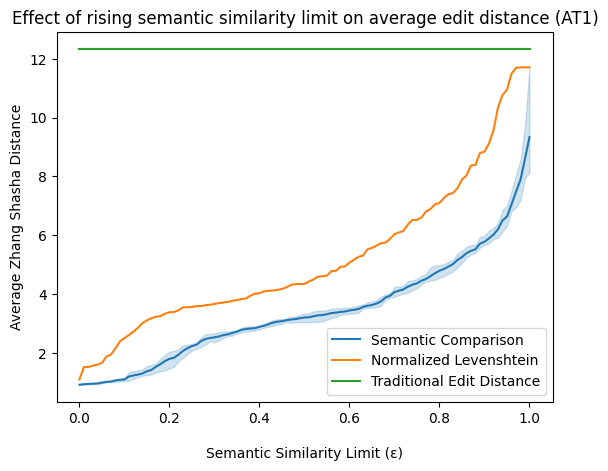

In [215]:
# print(ld2)
sns.lineplot(ld1, x="limit", y ="average distance", label = "Semantic Comparison")
# sns.lineplot(ld2, x="limit", y ="average distance", label = "all-mpnet-base-v2")
# sns.lineplot(ld3, x="limit", y ="average distance", label = "all-MiniLM-L12-v2")
sns.lineplot(ld4, x="limit", y ="average distance", label = "Normalized Levenshtein")
sns.lineplot(sldf, x="limit", y ="average distance", label = "Traditional Edit Distance")

plt.xlabel("\nSemantic Similarity Limit (ε)")
plt.ylabel("Average Zhang Shasha Distance")
# plt.xticks(fontsize=8, rotation=90)
plt.title("Effect of rising semantic similarity limit on average edit distance (AT1)")    

plt.savefig("img/similaritylimits2_at1.pdf", bbox_inches='tight')

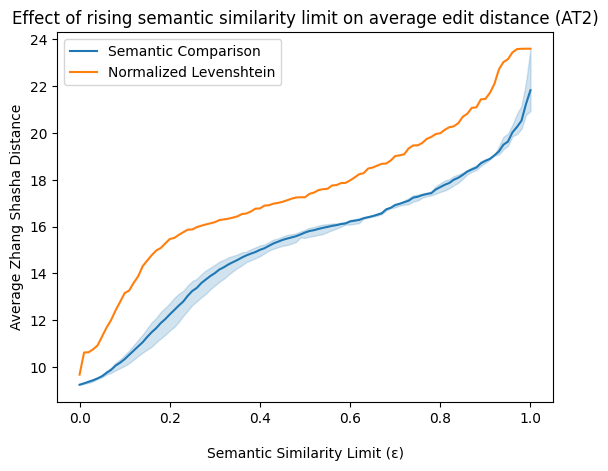

In [18]:
# print(ld2)
sns.lineplot(at2ld1, x="limit", y ="average distance", label = "Semantic Comparison")
# sns.lineplot(ld2, x="limit", y ="average distance", label = "all-mpnet-base-v2")
# sns.lineplot(ld3, x="limit", y ="average distance", label = "all-MiniLM-L12-v2")
sns.lineplot(at2ld4, x="limit", y ="average distance", label = "Normalized Levenshtein")
# sns.lineplot(sldf, x="limit", y ="average distance", label = "Traditional Edit Distance")

plt.xlabel("\nSemantic Similarity Limit (ε)")
plt.ylabel("Average Zhang Shasha Distance")
# plt.xticks(fontsize=8, rotation=90)
plt.title("Effect of rising semantic similarity limit on average edit distance (AT2)")    

plt.savefig("img/similaritylimits2_at2.pdf", bbox_inches='tight')

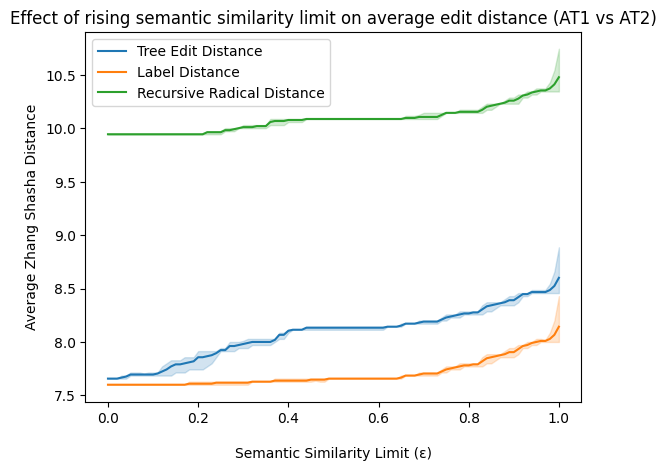

In [81]:
# print(at2ld1["average distance"], at12ld1["average distance"])
sns.lineplot(at12ld1, x="limit", y ="average distance", label = "Tree Edit Distance")
# sns.lineplot(ld2, x="limit", y ="average distance", label = "all-mpnet-base-v2")
# sns.lineplot(ld3, x="limit", y ="average distance", label = "all-MiniLM-L12-v2")
# sns.lineplot(at12ld4, x="limit", y ="average distance", label = "Normalized Levenshtein")
sns.lineplot(at12ld2, x="limit", y ="average distance", label = "Label Distance")
sns.lineplot(at12ld3, x="limit", y ="average distance", label = "Recursive Radical Distance")
# sns.lineplot(sldf, x="limit", y ="average distance", label = "Traditional Edit Distance")

plt.xlabel("\nSemantic Similarity Limit (ε)")
plt.ylabel("Average Zhang Shasha Distance")
# plt.xticks(fontsize=8, rotation=90)
plt.title("Effect of rising semantic similarity limit on average edit distance (AT1 vs AT2)")    

plt.savefig("img/similaritylimits2_at1-2.pdf", bbox_inches='tight')

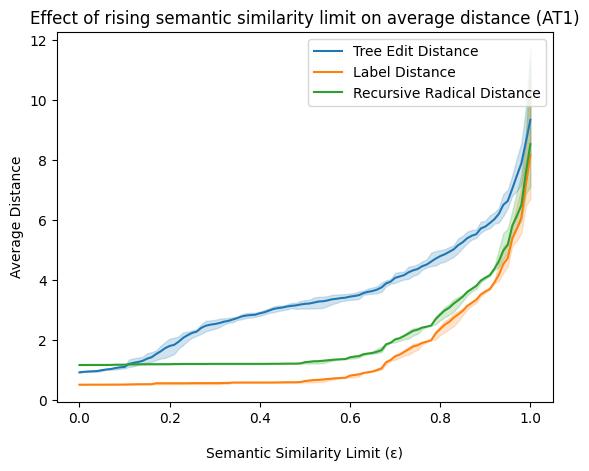

In [32]:
sns.lineplot(ld1, x="limit", y ="average distance", label = "Tree Edit Distance")
sns.lineplot(ld2, x="limit", y ="average distance", label = "Label Distance")
sns.lineplot(ld3, x="limit", y ="average distance", label = "Recursive Radical Distance")
# sns.lineplot(ld2, x="limit", y ="average distance", label = "all-mpnet-base-v2")
# sns.lineplot(ld3, x="limit", y ="average distance", label = "all-MiniLM-L12-v2")
# sns.lineplot(ld4, x="limit", y ="average distance", label = "Normalized Levenshtein")
# sns.lineplot(sldf, x="limit", y ="average distance", label = "Traditional Edit Distance")

plt.xlabel("\nSemantic Similarity Limit (ε)")
plt.ylabel("Average Distance")
# plt.xticks(fontsize=8, rotation=90)
plt.title("Effect of rising semantic similarity limit on average distance (AT1)")    

plt.savefig("img/similaritylimits_line_tree_comparison.pdf", bbox_inches='tight')

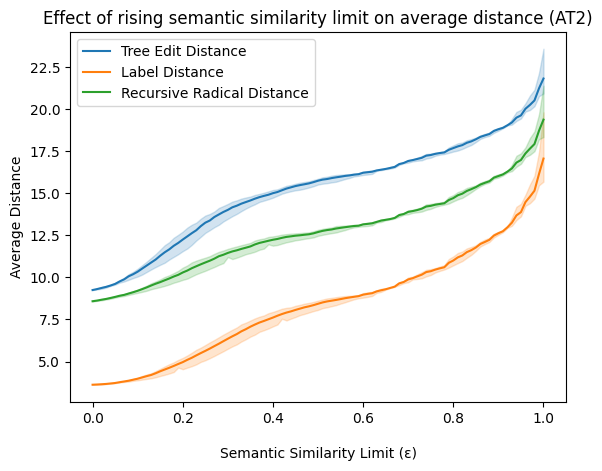

In [53]:
sns.lineplot(at2ld1, x="limit", y ="average distance", label = "Tree Edit Distance")
sns.lineplot(at2ld2, x="limit", y ="average distance", label = "Label Distance")
sns.lineplot(at2ld3, x="limit", y ="average distance", label = "Recursive Radical Distance")
# sns.lineplot(ld2, x="limit", y ="average distance", label = "all-mpnet-base-v2")
# sns.lineplot(ld3, x="limit", y ="average distance", label = "all-MiniLM-L12-v2")
# sns.lineplot(ld4, x="limit", y ="average distance", label = "Normalized Levenshtein")
# sns.lineplot(sldf, x="limit", y ="average distance", label = "Traditional Edit Distance")

plt.xlabel("\nSemantic Similarity Limit (ε)")
plt.ylabel("Average Distance")
# plt.xticks(fontsize=8, rotation=90)
plt.title("Effect of rising semantic similarity limit on average distance (AT2)")    

plt.savefig("img/similaritylimits_line_tree_comparison_at2.pdf", bbox_inches='tight')

In [90]:
print(type(f1[0][2]))
print(f1[0][2])
print(stat_mappings(f1[0][2][0]))

<class 'list'>
[('01', '02', [('Background data attack', 'Background Data Attack', 0.998, 'm'), ('Obtaining a sensitive dataset', 'Obtain Sensitive Dataset', 0.9376, 'm'), ('Linking the dataset', 'Request for Verification', 0.1298, 'm'), ('Unauthorized access to profile', 'Unauthorized Profile Access', 0.9852, 'm'), ('Gaining user credentials', 'Gain User Credentials', 0.9692, 'm'), ('Malware', 'Malware Attack', 0.9213, 'm'), ('Social engineering', 'Social Engineering Attack', 0.8413, 'm'), ('Credential creep', 'Credential Creep', 0.9356, 'm'), ('User profiling', 'User Profiling', 0.9806, 'm'), ('Request for additional data', 'Request Additional Data', 0.9593, 'm'), ('Gathering personal data', 'Obtain Personal Data', 0.8613, 'm'), ('Accessing the profile', 'Access Profile', 0.8473, 'm'), ('Remote access', 'Remote Access', 0.9948, 'm'), ('Stealing phone', 'Steal Phone', 0.9832, 'm')]), ('01', '03', [('Unauthorized access to profile', 'Unauthorized access to profile', 1.0, 'm'), ('Creden

IndexError: string index out of range

In [20]:
import Levenshtein

Levenshtein.distance("lewenstein", "levenshtein")

def lvs(a, b):
    print(compare(a, b), Levenshtein.distance(a,b))

lvs("obtain personal data", "obtain personnel")
lvs("obtain personal data", "gather private info")
lvs("break open safe", "break open door")
lvs("break open safe", "crack safe open")
lvs("crack safe", "crack door")
lvs("door open", "open door")
# print(compare("obtain personal data", "obtain personnel"))

not this
SentenceTransformer(
  (0): Transformer({'max_seq_length': 128, 'do_lower_case': False}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 384, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
  (2): Normalize()
) all-MiniLM-L12-v2
obtain personal data obtain personnel 0.3695
0.3695 7
obtain personal data gather private info 0.6267
0.6267 15
break open safe break open door 0.7125
0.7125 4
break open safe crack safe open 0.717
0.717 11
crack safe crack door 0.6199
0.6199 4
door open open door 0.9252
0.9252 8


# Refinement Awareness

In [23]:
#!/usr/bin/env python

import zss
OR = 0
AND = 1

def insert(a):
    return 1
def remove(a):
    return 1
lim = .75
def update(a, b):
    toRet = 0
    # if a.refinement != b.refinement:
    #     toRet += .5
    if stored_compare(a.label, b.label) < lim:
        toRet += 1
    return toRet

def update_g(a, b):
    toRet = 0
    if a.refinement != b.refinement:
        toRet += .5
    if stored_compare(a.label, b.label) < lim:
        toRet += 1
    return toRet

for i in range(1, 39):
    temp = []
    if int(i) < 10:
        i = "0" + str(i)
    for j in range(1, 39):
        # if k == lims[0]:
            # print("Processing: ", i, " & ",j)
        if int(j) < 10:
            j = "0" + str(j)
        T1 = xmlToZSSTree("data/AT1/ICS2-"+str(i)+".xml")
        T2 = xmlToZSSTree("data/AT1/ICS2-"+str(j)+".xml")
        dist = distance(T1, T2, AttackNode.get_children, insert, remove, update)
        dist2 = distance(T1, T2, AttackNode.get_children, insert, remove, update_g)
        print(i, j, dist, dist2)
# assert dist == 20

01 01 0.0 0.0
01 02 8.0 9.0
01 03 4.0 4.0
01 04 5.0 5.0
01 05 6.0 6.0
01 06 9.0 9.5
01 07 9.0 9.5
01 08 5.0 5.0
01 09 3.0 3.5
01 10 8.0 8.0
01 11 5.0 5.0
01 12 14.0 15.0
01 13 4.0 4.0
01 14 5.0 5.0
01 15 5.0 5.0
01 16 4.0 4.0
01 17 5.0 5.0
01 18 3.0 3.0
01 19 5.0 5.0
01 20 1.0 1.0
01 21 4.0 4.0
01 22 5.0 5.0
01 23 7.0 7.0
01 24 5.0 5.0
01 25 6.0 6.0
01 26 5.0 5.0
01 27 5.0 6.0
01 28 6.0 6.0
01 29 5.0 5.0
01 30 5.0 5.0
01 31 6.0 6.0
01 32 8.0 9.0
01 33 5.0 6.0
01 34 5.0 5.0
01 35 5.0 5.0
01 36 4.0 4.0
01 37 6.0 6.0
01 38 4.0 4.0
02 01 8.0 9.0
02 02 0.0 0.0
02 03 6.0 7.0
02 04 6.0 6.0
02 05 7.0 7.0
02 06 14.0 14.5
02 07 11.0 11.5
02 08 6.0 7.0
02 09 8.0 8.0
02 10 10.0 10.5
02 11 6.0 6.0
02 12 14.0 14.0
02 13 6.0 7.0
02 14 6.0 6.0
02 15 6.0 6.0
02 16 6.0 6.0
02 17 6.0 6.0
02 18 8.0 8.0
02 19 6.0 7.0
02 20 8.0 9.0
02 21 6.0 7.0
02 22 7.0 7.0
02 23 12.0 12.0
02 24 6.0 6.0
02 25 6.0 6.0
02 26 7.0 7.0
02 27 6.0 6.5
02 28 6.0 6.0
02 29 6.0 7.0
02 30 7.0 7.0
02 31 6.0 6.0
02 32 10.0 11.0
02 33 

# Node Flipping

In [213]:
def SemanticFlipping(T1, T2):
    M = [(T1,T2)]
    for m in M:
        print(m[0].label, m[1].label)
        D = np.zeros((len(m[0].children), len(m[1].children)))
        # print(D)
        for i, c1 in enumerate(m[0].children):
            for j, c2 in enumerate(m[1].children):
                D[i][j] = stored_compare(c1.label, c2.label)
        # print(D, type(D), np.max(D), np.where(D==np.max(D)))
        # print(np.where(D==np.max(D))[0][0], np.where(D==np.max(D))[1][0])
        M_t = []
        nc1 = []
        nc2 = []
        print(m[0].children)
        while D.size != 0:
            max = np.max(D)
            row = np.where(D==np.max(D))[0][0]
            col = np.where(D==np.max(D))[1][0]
            # print(D, max, row, col)
            M_t.append((m[0].children[row], m[1].children[col]))
            nc1.append(m[0].children[row])
            nc2.append(m[1].children[col])
            m[0].children.remove(m[0].children[row])
            m[1].children.remove(m[1].children[col])
            D = np.delete(D, row, 0)
            D = np.delete(D, col, 1)
    
        nc1.extend(m[0].children)
        nc2.extend(m[1].children)
        m[0].children = nc1.copy()
        m[1].children = nc2.copy()
        print(m[0].children)
        
        # print(M_t)
        M.extend(M_t)
    return T1, T2, M



# Handling Operations

101
101
101


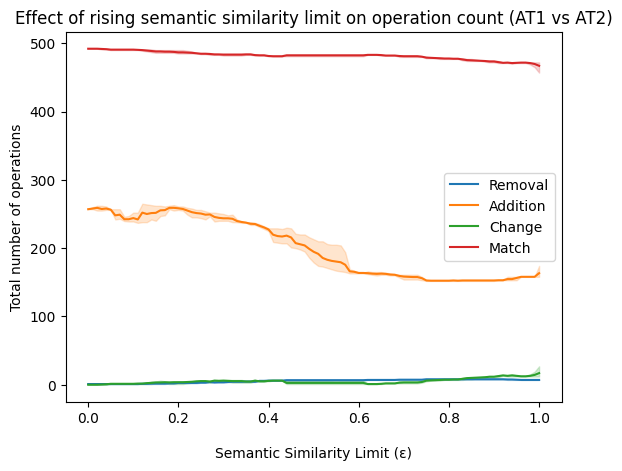

In [94]:
# i = 10
# j = 11
# lim = 1.001
# T1 = xmlToZSSTree("data/AT1/ICS2-"+str(i)+".xml")
# T2 = xmlToZSSTree("data/AT1/ICS2-"+str(j)+".xml")
# dist, Test = distance(T1, T2, AttackNode.get_children, insert, remove, update, True)
# print(Test)
# for i, op in enumerate(Test):
#     if op.type == 0:
#         print(str(i) + ") Removing: "+ op.arg1.label)
#     elif op.type == 1:
#         print(str(i) + ") Adding: "+ op.arg2.label)
#     elif op.type == 2:
#         print(str(i) + ") Changing: "+ op.arg1.label + " --> " + op.arg2.label)
#     elif op.type == 3:
#         print(str(i) + ") Matching: "+ op.arg1.label + " == " + op.arg2.label)

def enumerate_operations(ops):
    for i, op in enumerate(ops):
        if op.type == 0:
            print(str(i) + ") Removing: "+ op.arg1.label)
        elif op.type == 1:
            print(str(i) + ") Adding: "+ op.arg2.label)
        elif op.type == 2:
            print(str(i) + ") Changing: "+ op.arg1.label + " --> " + op.arg2.label)
        elif op.type == 3:
            print(str(i) + ") Matching: "+ op.arg1.label + " == " + op.arg2.label)

def count_operations(ops):
    count = {0:0, 1:0, 2:0, 3:0}
    for op in ops:
        op = op[2] # Operations are enumerated as lists nested in tuples
        # print(op)
        for i in op:
            count[i[0]] += 1
    return count



# def changed_operation(ops):
#     changed = {}
#     for op in ops:
#         op = op[2] # Operations are enumerated as lists nested in tuples
#         for i in op:
#             if i.type == 2:
#                 args = [i[1], i[2]]
#                 args.sort()
#                 if not args[0] in changed.keys():
#                     changed[args[0]] = {}
#                 changed[args[0]][args[1]]
data = []
for mk in ['paraphrase-multilingual-MiniLM-L12-v2', 'all-mpnet-base-v2', 'all-MiniLM-L12-v2']:#, "normalized_levenshtein"]:
    with open('AT1-2_101lims_mk_'+str(mk)+'_w_ops', 'rb') as fp:
        d1 = pickle.load(fp)
        print(len(d1))
    for i in d1:
        row = []
        co = count_operations(i[2])
        row.append(i[0])
        row.append(mk)
        for j in [0,1,2,3]:
            row.append(co[j])
        data.append(row)
    
    
df = pd.DataFrame(data)
df.columns = ["limit", "Model", "Removal", "Addition", "Change", "Match"]


sns.lineplot(df, x="limit", y ="Removal", label = "Removal")
sns.lineplot(df, x="limit", y ="Addition", label = "Addition")
sns.lineplot(df, x="limit", y ="Change", label = "Change")
sns.lineplot(df, x="limit", y ="Match", label = "Match")
plt.xlabel("\nSemantic Similarity Limit (ε)")
plt.ylabel("Total number of operations")
# plt.xticks(fontsize=8, rotation=90)
plt.title("Effect of rising semantic similarity limit on operation count (AT1 vs AT2)")    

plt.savefig("img/operation_count_AT12.pdf", bbox_inches='tight')

In [18]:
print(store.keys())
mk = "paraphrase-multilingual-MiniLM-L12-v2"
for i in store[mk].keys():
    for j in store[mk][i].keys():
         if store[mk][i][j] < 0:
            print(i, j, store[mk][i][j])
            store[mk][i][j] = abs(store[mk][i][j])
             
        # print(store["all-MiniLM-L12-v2"][i][j])


dict_keys(['paraphrase-multilingual-MiniLM-L12-v2'])


# Label Distance

7
{'m': 9, 'a': 0, 'r': 3, 'c': 4}


<Axes: >

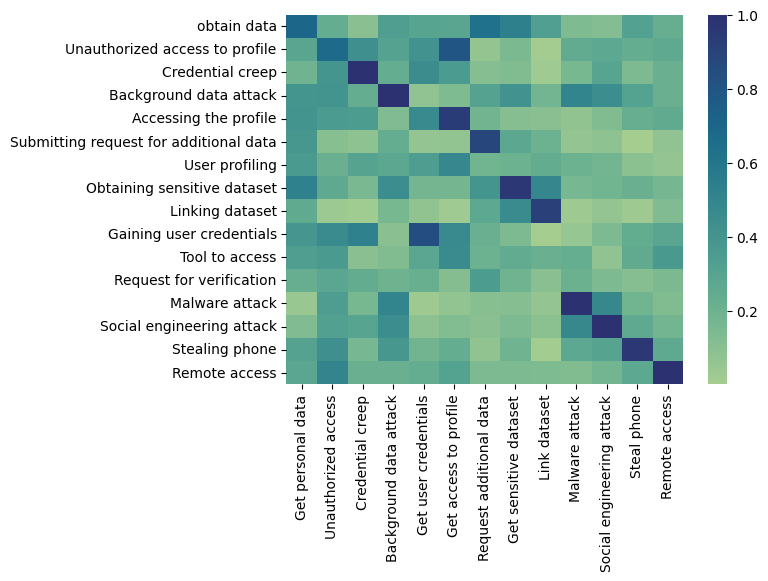

In [171]:
def compare_lists(list1, list2, indirect=True, lim=0):
    comparisons = []
    for i in range(len(list1)):
        temp = []
        for j in range(len(list2)):
            if indirect == True:
                temp.append(stored_compare(list1[i][0], list2[j][0]))
            elif indirect == "jaccard":
                temp.append(jaccard_distance(list1[i], list2[j], lim))
            else:
                temp.append(stored_compare(list1[i], list2[j]))
        comparisons.append(temp)
    axis0 = []
    for i in list1:
        if indirect == True:
            axis0.append(i[0])
        else:
             axis0.append(str(i))
    axis1 = []
    for i in list2:
        # print(i)
        if indirect == True:
            axis1.append(i[0])
        else:
            axis1.append(str(i))

    # print(axis1, axis0, len(axis1), len(axis0))

    df = pd.DataFrame(comparisons, index = axis0)
    df.columns = axis1
    
    return df, list1, list2, comparisons

def label_distance_matrix(T1, T2):
    dict1 = number_tree(T1)
    dict2 = number_tree(T2)
    list1 = []
    list2 = []
    for depth in dict1.keys():
        for node in dict1[depth]:
            list1.append((node.label, node.depth, node.position))
    for depth in dict2.keys():
        for node in dict2[depth]:
            list2.append((node.label, node.depth, node.position))    
    return compare_lists(list1, list2)


def label_distance(T1, T2, limit=0, numbered=False):
    dist = 0
    df, list1, list2 = label_distance_matrix(T1, T2)[0:3]
    #rowlist, with labels depths and positions
    rl = pd.DataFrame(list1, columns=["label", "depth", "position"])
    rl = rl.set_index("label")
    #columnlist, with labels depths and positions
    cl = pd.DataFrame(list2, columns=["label", "depth", "position"])
    cl = cl.set_index("label")
    maxcol = df.max().idxmax()
    maxrow = df[maxcol].idxmax()
    # print(rl.columns
    # print(maxrow)
    # print("\n\n\n\n\n")
    # print(rl.loc[maxrow]["depth"])
    # rl = rl.drop(maxrow, axis='index')
    # print("\n\n\n\n\n")
    # print(rl)
    # # print(rl[rl[0] == "Unauthorized access to profile"])
    # print("\n\n\n\n\n")
    mappings = []
    # print(df.argmax())
    while not df.empty:
        maxcol = df.max().idxmax()
        maxrow = df[maxcol].idxmax()
        sim = df[maxcol][maxrow]
        df = df.drop(maxrow, axis='index')
        df = df.drop(maxcol, axis='columns')
        if numbered:
            mc = maxcol + "_" + str(cl.loc[maxcol]["depth"]) + "_" + str(cl.loc[maxcol]["position"])
            mr = maxrow + "_" + str(rl.loc[maxrow]["depth"]) + "_" + str(rl.loc[maxrow]["position"])
            rl = rl.drop(maxrow, axis='index')
            cl = cl.drop(maxcol, axis='index')
            maxcol = mc
            maxrow = mr
        else:
            rl = rl.drop(maxrow, axis='index')
            cl = cl.drop(maxcol, axis='index')
            
        if sim >= limit:
            mappings.append((maxrow, maxcol, sim, "m"))
        else:
            dist += 1
            mappings.append((maxrow, "Λ", sim, "c"))
            mappings.append(("Λ", maxcol, sim, "c"))
    # print(rl, cl)
    for index, row in rl.iterrows():
        name = index
        if numbered:
            name += "_" + str(row["depth"]) + "_" + str(row["position"])
        mappings.append((name, "Λ", 0, "r"))
        dist += 1
    for index, row in cl.iterrows():
        name = index
        if numbered:
            name += "_" + str(row["depth"]) + "_" + str(row["position"])
        mappings.append(("Λ", name, 0, "a"))
        dist += 1
    return dist, mappings

def stat_mappings(mappings):
    dict = {"m":0, "a":0, "r":0, "c":0}
    for m in mappings:
        # print()
        dict[m[3]] += 1
    dict["c"] = int(dict["c"]/2)
    return dict
    

i = 10
j = 16

T1 = xmlToZSSTree("data/AT1/ICS2-"+str(i)+".xml")
T2 = xmlToZSSTree("data/AT1/ICS2-"+str(j)+".xml")

ld, mappings = label_distance(T1, T2, .9)
print(ld)
print(stat_mappings(mappings))
sns.heatmap(label_distance_matrix(T1, T2)[0], annot=False, cmap="crest")



# Recursive Radical Distance

In [23]:
def make_radical(T):
    children = []
    for i in T.children:
        children.append(i.label)
    return AttackNode(T.label, T.refinement, children)

def find_roots(T):
    # print("\n", T)
    roots = [T]
    for node in T.children:
        if len(node.children) > 0:
            roots.extend(find_roots(node))
    return roots

def make_radical_dictionary(T):
    dict = {}
    toVisit = find_roots(T)
    # print(toVisit)
    for node in toVisit:
        dict[node.label] = make_radical(node)
    return dict


def map_radical_roots(df, list1, list2):
    rl = pd.DataFrame(list1, columns=["label"])
    rl = rl.set_index("label")
    #columnlist, with labels depths and positions
    cl = pd.DataFrame(list2, columns=["label"])
    cl = cl.set_index("label")
    mappings = []
    # print(df.argmax())
    while not df.empty:
        maxcol = df.max().idxmax()
        maxrow = df[maxcol].idxmax()
        sim = df[maxcol][maxrow]
        df = df.drop(maxrow, axis='index')
        df = df.drop(maxcol, axis='columns')
        
        rl = rl.drop(maxrow, axis='index')
        cl = cl.drop(maxcol, axis='index')

        # We don't do thresholding here
        mappings.append((maxrow, maxcol))
    # print(rl, cl)
    for index, row in rl.iterrows():
        name = index
        mappings.append((name, "Λ"))
    for index, row in cl.iterrows():
        name = index
        mappings.append(("Λ", name))
        
    return mappings

def check_mapping(mappings, rad, pos):
    for m in mappings:
        if m[pos] == rad:
            return False
    return True

def compare_radicals(mappings, rad1, rad2, limit = 0):
    dist = 0
    map = []
    if rad1 != "Λ" and rad2 != "Λ":
        root_sim = stored_compare(rad1.label, rad2.label)
        if root_sim < limit:
            dist += 1
        if rad1.refinement != rad2.refinement:
            dist += 0.5
        if dist == 0:
            map.append((rad1.label, rad2.label, root_sim, "m"))
        else:
            map.append((rad1.label, "Λ", dist, "c"))
            map.append(("Λ", rad2.label, dist, "c"))
    else:
        if rad1 != "Λ":
            map.append((rad1.label, "Λ", dist, "r"))
            dist += 1
        if rad2 != "Λ":
            map.append(("Λ", rad2.label, dist, "a"))
            dist += 1
    if rad1 != "Λ" and rad2 != "Λ":
        df, l1, l2, c = compare_lists(rad1.children, rad2.children, False)
        rl = pd.DataFrame(l1, columns=["label"])
        rl = rl.set_index("label")
        #columnlist, with labels depths and positions
        cl = pd.DataFrame(l2, columns=["label"])
        cl = cl.set_index("label")
        
        while not df.empty:
            maxcol = df.max().idxmax()
            maxrow = df[maxcol].idxmax()
            sim = df[maxcol][maxrow]
            df = df.drop(maxrow, axis='index')
            df = df.drop(maxcol, axis='columns')
            rl = rl.drop(maxrow, axis='index')
            cl = cl.drop(maxcol, axis='index')
            if check_mapping(mappings, maxrow, 0) and check_mapping(mappings, maxcol, 1):
                if sim >= limit:
                    map.append((maxrow, maxcol, sim, "m"))
                else:
                    dist += 1
                    map.append((maxrow, "Λ", sim, "c"))
                    map.append(("Λ", maxcol, sim, "c"))
        # print(rl, cl)
        for index, row in rl.iterrows():
            name = index
            if check_mapping(mappings, name, 0):
                map.append((name, "Λ", 0, "r"))
                dist += 1
        for index, row in cl.iterrows():
            name = index
            if check_mapping(mappings, name, 1):
                map.append(("Λ", name, 0, "a"))
                dist += 1
    elif rad1 == "Λ":
        for c in rad2.children:
            if check_mapping(mappings, c, 1):
                map.append(("Λ", c, 0, "a"))
                dist += 1
    elif rad2 == "Λ": 
        for c in rad1.children:
            if check_mapping(mappings, c, 0):
                map.append((c, "Λ", 0, "r"))
                dist += 1
        
    return dist, map
    

def recursive_radical_distance(T1, T2, limit=0):
    raddict1 = make_radical_dictionary(T1)
    raddict2 = make_radical_dictionary(T2)
    df, l1, l2, c = compare_lists(list(raddict1.keys()), list(raddict2.keys()), False)
    mapping = map_radical_roots(df, l1, l2)
    dist = 0
    map = []
    for m in mapping:
        rad1 = m[0]
        rad2 = m[1]
        if m[0] != "Λ": 
            rad1 = raddict1[m[0]]
        if m[1] != "Λ":
            rad2 = raddict2[m[1]]
        d, m = compare_radicals(mapping, rad1, rad2, limit)
        dist += d
        map.extend(m)

    return dist, map
    
i = 10
j = 12
T1 = xmlToZSSTree("data/AT1/ICS2-"+str(i)+".xml")

# for key in raddict1.keys():
#     print(key, ": ", raddict1[key])
# print()
T2 = xmlToZSSTree("data/AT1/ICS2-"+str(j)+".xml")

# for key in raddict2.keys():
#     print(key, ": ", raddict2[key])

# print("\n--\n")
# print(mapping)
# print("\n\n")
# print(raddict1.keys())
# print("\n\n")
# print(raddict2.keys())
# print("\n--\n")

print(label_distance(T1, T2, .9))
print(recursive_radical_distance(T1, T2, .9))




(4, [('Credential creep', 'Credential creep', 1.0, 'm'), ('Background data attack', 'Background data attack', 1.0, 'm'), ('Unauthorized access to profile', 'Unauthorized access to profile', 1.0, 'm'), ('User profiling', 'user profiling', 1.0, 'm'), ('Accessing the profile', 'accessing the profile', 1.0, 'm'), ('Gaining user credentials', 'gaining user credentials', 1.0, 'm'), ('Remote access', 'remote access', 1.0, 'm'), ('Malware attack', 'malware attack', 1.0, 'm'), ('Social engineering attack', 'social engineering attack', 1.0, 'm'), ('Submitting request for additional data', 'submitting a request for additional data', 0.9946, 'm'), ('Obtaining sensitive dataset', 'obtaining a sensitive dataset', 0.9928, 'm'), ('Stealing phone', 'steal phone', 0.9579, 'm'), ('Linking dataset', 'Λ', 0, 'c'), ('Λ', 'linking the dataset via a request for verification', 0, 'c'), ('obtain data', 'Λ', 0, 'c'), ('Λ', 'Obtain personal data', 0, 'c'), ('Tool to access', 'Λ', 0, 'r'), ('Request for verificati

# Multiset Distance

In [245]:


def find_leaves(T):
    # print("\n", T.label)
    leaves = []
    for node in T.children:
        if node.children == []:
            # print(node)
            leaves.append(node)
        else:    
            leaves.extend(find_leaves(node))
    return leaves

# def find_vector(leaf, vector):
#     vector = []
#     if leaf.parent.refinement == AND:
#         for child in leaf.parent.children:
#             if not child in vector:
#                 vector.append(child)
#     vector.extend(leaf.parent)
                


    

# print(T1)
# print()
# leaf = find_leaves(T1)
# for l in leaf:
#     print(l.label)
#     print(l.get_multiset())


def jaccard_distance(L1, L2, limit=0, return_mappings=False):
    df, list1, list2, m = compare_lists(L1, L2, False, limit)
    # print("\n", df, "\n")
    rl = pd.DataFrame(list1, columns=["label"])
    rl = rl.set_index("label")
    #columnlist, with labels depths and positions
    cl = pd.DataFrame(list2, columns=["label"])
    cl = cl.set_index("label")
    dist = 0
    mappings = []
    # print(df.argmax())
    while not df.empty:
        maxcol = df.max().idxmax()
        maxrow = df[maxcol].idxmax()
        sim = df[maxcol][maxrow]
        df = df.drop(maxrow, axis='index')
        df = df.drop(maxcol, axis='columns')
        rl = rl.drop(maxrow, axis='index')
        cl = cl.drop(maxcol, axis='index')

        if sim > limit:
            mappings.append((maxrow, maxcol, sim, "m"))
        else:
            dist += 1
            mappings.append((maxrow, "Λ", sim, "c"))
            mappings.append(("Λ", maxcol, sim, "c"))
        
    # print(rl, cl)
    for index, row in rl.iterrows():
        dist += 1
        name = index
        mappings.append((name, "Λ", 0, "r"))
    for index, row in cl.iterrows():
        dist += 1
        name = index
        mappings.append(("Λ", name, 0, "a"))
    if return_mappings == True:
        return dist, mappings
    return dist


def multiset_distance(T1, T2, lim=0):
    ms1 = T1.get_multiset()
    ms2 = T2.get_multiset()
    df, list1, list2, m = compare_lists(ms1, ms2, "jaccard", lim)
    list1 = [str(i) for i in list1]
    list2 = [str(i) for i in list2]
    rl = pd.DataFrame(list1, columns=["label"])
    rl = rl.set_index("label")
    #columnlist, with labels depths and positions
    cl = pd.DataFrame(list2, columns=["label"])
    cl = cl.set_index("label")
    # print("\n\n")
    # print(df.columns, "\n\n\n", len(rl), len(cl), "DF")
    # print("\n\n")
    dist = 0
    mappings = []
    # print(df.argmax())
    while not df.empty:
        mincol = df.min().idxmin()
        minrow = df[mincol].idxmin()
        sim = df[mincol][minrow]
        df = df.drop(minrow, axis='index')
        df = df.drop(mincol, axis='columns')
        rl = rl.drop(minrow, axis='index')
        cl = cl.drop(mincol, axis='index')
        # print(mincol, minrow, mappings, "\n")
        d, m = jaccard_distance([i.strip("\"',[] ") for i in minrow.split("',")], [i.strip("\"',[] ") for i in mincol.split("',")], lim, True)
        # print("\n", d, minrow, mincol, m)
        dist += d
        mappings.extend(m)
        # if sim == 0:
        #     # print([i.strip("\"',[] ") for i in minrow.split("',")], [i.strip("\"',[] ") for i in minrow.split("',")], type(minrow), type(mincol))
        #     # print(, lim, True))
        #     d, m = jaccard_distance([i.strip("\"',[] ") for i in minrow.split("',")], [i.strip("\"',[] ") for i in minrow.split("',")], lim, True)
        #     mappings.extend(m)
        # else:
        #     dist += sim
        #     d, m = jaccard_distance([i.strip("\"',[] ") for i in minrow.split("',")], [i.strip("\"',[] ") for i in minrow.split("',")], lim, True)
        #     mappings.extend(m)
        
    # print(rl, cl)
    for index, row in rl.iterrows():
        name = [i.strip("\"',[] ") for i in index.split("',")]
        for n in name:
            dist += 1
            mappings.append((n, "Λ", 0, "r"))
    for index, row in cl.iterrows():
        
        name = [i.strip("\"',[] ") for i in index.split("',")]
        for n in name:
            dist += 1
            mappings.append(("Λ", n, 0, "a"))
    return dist, mappings



i = 10
j = 10
T1 = xmlToZSSTree("data/AT1/ICS2-"+str(i)+".xml")
T2 = xmlToZSSTree("data/AT2/ICS2-"+str(j)+".xml")
d, m = multiset_distance(T1, T2, .9)
print(d)
print(stat_mappings(m))
print(m)
                



15
{'m': 4, 'a': 7, 'r': 0, 'c': 8}
[('Submitting request for additional data', 'Submitting request for additional data', 1.0, 'm'), ('Stealing phone', 'Stealing phone', 1.0, 'm'), ('Malware attack', 'Λ', 0.7226, 'c'), ('Λ', 'Getting required software for malware attack', 0.7226, 'c'), ('Stealing phone', 'Stealing phone', 1.0, 'm'), ('Social engineering attack', 'Λ', 0.5148, 'c'), ('Λ', 'Phishing', 0.5148, 'c'), ('User profiling', 'Λ', 0.4936, 'c'), ('Λ', 'Website tracking', 0.4936, 'c'), ('Request for verification', 'Request for verification', 1.0, 'm'), ('Obtaining sensitive dataset', 'Λ', 0.1769, 'c'), ('Λ', 'Negligent insider', 0.1769, 'c'), ('Remote access', 'Λ', 0.7789, 'c'), ('Λ', 'Getting tool for remote access', 0.7789, 'c'), ('Malware attack', 'Λ', 0.7226, 'c'), ('Λ', 'Getting required software for malware attack', 0.7226, 'c'), ('Remote access', 'Λ', 0.7789, 'c'), ('Λ', 'Getting tool for remote access', 0.7789, 'c'), ('Social engineering attack', 'Λ', 0.5148, 'c'), ('Λ', 'Ph